# [Public Policy 275] Spatial Data and Analysis, Fall 2019

# Lab 6: Dynamic Fields & Policy Design

* University of California, Berkeley
* Instructor: Solomon Hsiang
* TA: Luna Yue Huang, Jay Sayre

**About This Lab**
* Due Date: October 30th, 2019
* You may talk with other students about the lab, but each student is responsible for doing all exercises in the lab themselves and turning in their own write up. We will be checking code for evidence of copying and pasting.
* When you are done with the lab, please restart the kernel and run all the codes one more time (press the ">>" button), so that the grader will see a clean notebook. Don't forget to save! Please submit this lab to bCourses as `YOURCAL1ID.ipynb`. This will facilitate anonymous grading.
* The class just recently transitioned from Matlab to Python. This is a newly developed assignment, so if you think there is an error or something is unclear, let us know right away. That will be extremely helpful to us and your fellow students.
* This lab requires that you download the following files and place them in the same directory as this jupyter notebook:
    * `Lab6_AustraliaRainfall.nc`
* These labs have been developed over the years by Solomon Hsiang, and past/current GSIs including Ian Bolliger, Tamma Carleton, Shubham Goel, Felipe González, Luna Yue Huang, Jonathan Kadish, Jonathan Proctor and James Sayre (in alphabetical order).

## Objectives
By the end of this lab, you will be able to
1. Write more functions in Python
2. Use the package `xarray` to work with higher dimensional arrays in Python

## 0. Installing Packages

Let's begin by installing `xarray` and some of its dependencies (namely netCDF4, which is used for reading netCDF files, a very common storage format for meteorological/atmospheric data). At the command line, run

```bash
conda install xarray netCDF4
```

to install both the xarray and netCDF4 packages. `conda` is the preferred way to resolve dependency issues, but if this doesn't work, try running 

```bash
pip install xarray
```

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, linregress
import geopandas as gpd
import shapely
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon, LineString
from shapely.affinity import scale
from rasterio.features import geometry_mask
from rasterio.transform import xy
from affine import Affine

%matplotlib inline

## Before you get started: More on functions

So far we have introduced that you could write functions within a script and then call it. However, if you do this, your codes will become longer and longer once you want to do something more complicated. Instead, you could create a new "module" (a .py file) that contains your function, and by running the command `import MyModule`, where the name of your "module" is `MyModule.py` and the "module" is placed in the same directory as your current script, then you could call a function defined elsewhere (see [this](https://developer.rhino3d.com/guides/rhinopython/python-remote-local-module/) for more information). This proves to be very helpful when you start to work on larger projects (e.g., this and the next lab) with more functions and want to organize them properly.

Start by creating a very simple function `add_one()` that will take the input value and return an output that is equal to the input plus one. Write the following code block into `MyModule.py`, i.e. create a blank text file with this name and copy-paste and save your function above in the file.

```python
def add_one(input_number):
    """Adds one to the input number.
    
    Args:
        input_number (int or float): input number

    Returns:
        int or float: input number + 1
    """
    print('Thinking...')
    final_answer = input_number + 1
    print('DONE!')
    return final_answer
```

Note that the `print()` commands tells Python to display text that tells the user where computer is in its calculation (always a good idea!) and it executes the calculation: we take the argument `input_number` supplied by the user and add one to it, creating the variable `final_answer`. The command `return` tells Python to display the output of the function as the value stored in the variable `final_answer` when the function is completed. Try leaving out the `return` line in the function - what happens to the output of the function? Without specifying what to return, the function will not know which value to output and returns `None` by default (note that the `print()` lines will still appear, though).

You could then import and run the function here in this script.

```python
import MyModule
test1 = MyModule.AddOne(3)
test2 = MyModule.AddOne(AddOne(3))
print(test1)
print(test2)
```

Note that you can remove the reference to the module name (i.e. `MyModule.AddOne` above) by either running 

```python
from MyModule import add_one
```

or

```python
from MyModule import *
```

the first line imports just the `add_one()` function to the python namespace, the second of which imports all functions provided by the module to the python namespace (in general, the latter can be a bit dangerous if different modules have similarly named functions, as functions from one module can be overwritten by another). For instance, if you were to import everything from both `scipy` and `numpy` and wanted to use the `log10()` function, in numpy `log10` is a function that returns NaNs for negative arguments, whereas in scipy `log10()` returns complex values for negative arguments, so be careful to confirm that you'll be using the function with the behavior you want!

Of course, you can also write more sophisticated functions that output multiple matrices, save files, generate graphs, etc.

## 1. Drought Down Under

Australia is often referred to as the driest inhabited continent (Antarctica is the driest by most measures). In this section, we'll look at some real rainfall data and try to characterize certain aspects of it, including the recent drought.

### Higher Dimension Arrays

Before we get to the data, you have to get familiar with information stored in higher dimension arrays. Earlier we were looking at data that was in a 2D array: each element was described by two coordinates, row and column. But there are many situations where this is not enough and it is much more convenient to store data in arrays with more coordinates (once they stop being two dimensions, we usually don't refer to to them as matrices anymore and just call them the more general term array, note that numpy refers to both matrices and higher dimension arrays as arrays (numpy does actually have a class matrix, but it is not recommended that you use it for any purpose. The matrix class will soon be deprecated)).

Each element in a three dimensional array is described by three coordinates $(i, j, k)$ rather than just two $(i, j)$. You can picture it as having rows, columns, and layers (where each layer is a matrix with rows and columns just like a usual matrix). The layer index just describes which of the matrices you are looking at. And once you specify the layer index ($k$) it's just like working with a regular matrix. The best way to get a feel for this is to make a 3D array.

Create a 2D matrix and call it `A`. Create another one the same size, but with different elements, and call it `B`.

```python
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])
```

Now use the array function provided by numpy to "stack" them on top of each other in a third dimension. Run

```python
C = np.array([A, B])
```

and examine the output by taking a look at the array C created by the line above. In this syntax, note that we could easily stack more than two matrices in the third dimension.  Note that running `C[0, :]` returns matrix `A` and `C[1, :]` returns matrix `B` (and also that you can only specify the layer `k` in the arguments here, and don't need to specify that there are 3 indices $i, j$ and $k$). Examining the 3d array, note that the numpy syntax here would be $C[k, i, j]$ to access elements of the array.

Next, run
```python
D = np.concatenate((A, B), axis=0)
D = np.vstack((A, B))  # this and the line above are equivalent
```

and note that this stacks the two arrays vertically and produce a 2D matrix that has twice as many rows.

Then, run
```python
E = np.concatenate((A, B), axis=1)
E = np.hstack((A, B))  # this and the line above are equivalent
E
```

This places the arrays side by side to make a 2D matrix that has twice as many columns. And ```np.array([A, B])``` places the arrays "on top" of each other, so that in each position where there used to be just a single entry, there is now a vector. So to reach a specific element, one must specify the layer of the array ($k$) and then the position of the  element within that layer ($i,j$). (Side note: when code and data structures become more elaborate, it’s usually helpful to draw out the dimensions of the arrays and operations on some scrap paper, it can help you avoid costly mistakes and confusion.)

Three dimensional arrays are still rather intuitive, because we can picture three dimensions well. However, sometimes even three dimensions are not enough. Numpy is very good at working with arrays of any dimension, it simply expands the number of indices used to specify the location of an element. For example, an element in a four-dimensional array has four indices to specify the location of an entry (i, j, k, l). A ten-dimensional array has ten (i, j, k, l, m, n, p, q, r, s). 

Run the code below to examine a four dimensional array:

```python
F = np.array([C, 3 * C])
```

Load the data in the netCDF file `Lab6_AustraliaRainfall.nc` (note: this requires either the `scipy` package or the `netCDF4-Python` library to be installed). The source, units and structure of the data are described in the file. We will use the xarray package and the `open_dataset()` function. Type `ds.sizes` to check the size and dimensionality of the main data array: this will list the name for each dimension of the array and the number listed describes how many elements the array has in that particular dimension. Type `ds` to examine the overall structure of the data, the data matrices, and the metadata.

Examine the actual data stored in the xarray Dataset using the command `ds['rainfall']`.  Be sure that you understand the resolution of the data and that your variables all make sense to you.

In [2]:
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])
C = np.array([A, B])
D = np.concatenate((A, B), axis=0)
D = np.vstack((A, B))
E = np.concatenate((A, B), axis=1)
E = np.hstack((A, B))
F = np.array([C, C * 3])

**1.1 Visualize the rainfall pattern for January of 1970.**

To do this, you must determine which indices specify those dates. This can be done in more programmatic ways using tools provided by xarray, but for now let's just do this using the 4 dimensional matrix `ds['rainfall']` (this is a xarray DataArray object, but for our purposes we can work with it similarly to a numpy array in terms of position indexing). Use the colon `[:]` when you want to call all the data in a certain dimension (e.g. latitude). Orient and label your plot.

Hint: try using xarray's `.plot()` function, which makes this nice and easy.

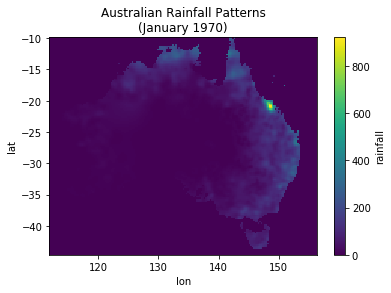

In [4]:
ds = xr.load_dataset('/Users/iRene/Documents/School/Fall 2019/PP275/Lab06/Lab6_AustraliaRainfall.nc')

ds['rainfall'][:, :, 0 , 0].plot()
plt.title('Australian Rainfall Patterns\n(January 1970)');

In [10]:
ds

<xarray.Dataset>
Dimensions:   (lat: 139, lon: 178, month: 12, year: 38)
Coordinates:
  * lat       (lat) float64 -44.5 -44.25 -44.0 -43.75 ... -10.5 -10.25 -10.0
  * lon       (lon) float64 112.0 112.2 112.5 112.8 ... 155.5 155.8 156.0 156.2
  * year      (year) uint16 1970 1971 1972 1973 1974 ... 2004 2005 2006 2007
  * month     (month) uint8 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    rainfall  (lat, lon, year, month) float64 0.0 0.0 0.0 0.0 ... nan nan nan
Attributes:
    Description:  Monthly rainfall in mm during 1970-2007
    Info:         Dimensions of matrix rainfall are (lat lon year month)
    Source:       AUSTRALIAN BUREAU OF METEROLOGY

**1.2**

It should be clear now why four dimensions are used for this data instead of three. One could have simply stacked the monthly observations sequentially in the third dimension, but then isolating individual months or individual years would involve counting by twelve over and over, or some similar operation. Here, isolating an individual month, an individual year, or a set of the same months or sequence of years are all relatively simple operations. The only awkward part of using this array is figuring out which layer corresponds to which year, since the first layer is not year 1. For this data set it is trivial to examine the vector `ds['year']` and determine which layer one is looking for, but this may not be true for larger data sets. For this problem, a useful command to know is `.sel()`, `ds.sel(year=1990)` returns the dataset where the year is equal in value to 1990. Note that by doing this, we have subsetted the dataset down in one dimension (i.e. only taking the year 1990), so the resulting data set will be three dimensional. There are other equivalent ways to do this. For instance, xarray supports the use of both labels and positional indexing.

Positional indexing can be used similarly, as long as we can determine the position of each label in the index. To perform this, we can look up the $i$ position of the label we want (say 1990) in the list of years of the dataset. To do so, we can use the command `k_year = list(ds['year']).index(1990)` to save the $i$ index of the year 1990 to the variable ```k_year```. Using this, we can subset down the data using either of the commands:

```python
ds.isel(year=k_year)  
ds[:, :, k_year, :]
```

all return a 3 dimensional array where the year is 1990.

We can use any of the methods above to compute the monthly average rainfall in 1990, e.g. using the code 

```python
ds.sel(year=1990)['rainfall'].mean(dim='month')
```

where we specify that the mean should be across months, not latitudes or longitudes (try this though for yourself, and see what the output gives you).

**Now visualize the average rainfall for all Januaries and all Junes in the sample using the command mean. 
This function can take the average of the data along any dimension, so long as you specify it. Be sure to determine which dimension you want to average over to get the average rainfall for a single month. Plot the maps of average rainfall as two subplots in a single figure. Make sure the color axis for the two subplots is the same so that readers are not mislead by a changing color scheme.**

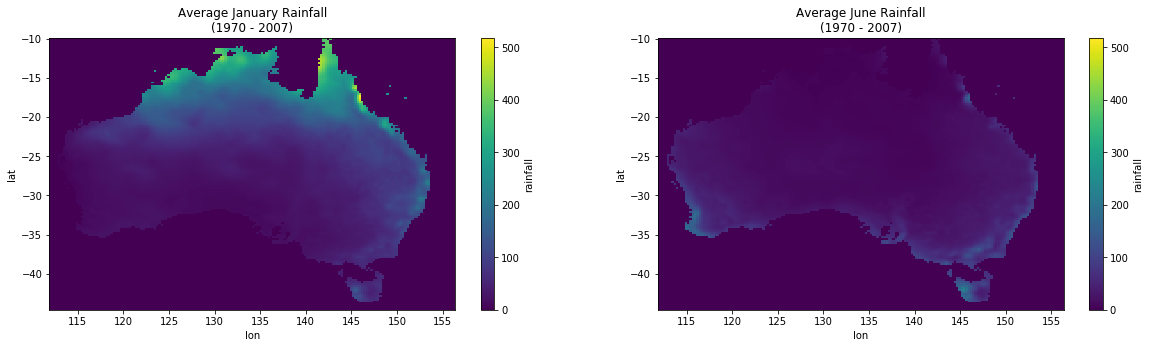

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
rainfall_jan = ds.sel(month=1)['rainfall'].mean(dim='year')
rainfall_jun = ds.sel(month=6)['rainfall'].mean(dim='year')
cmax = max([rainfall_jan.max(), rainfall_jun.max()])
rainfall_jan.plot(ax=axes[0], vmax=cmax)
axes[0].set_title('Average January Rainfall\n(1970 - 2007)')
rainfall_jun.plot(ax=axes[1], vmax=cmax)
axes[1].set_title('Average June Rainfall\n(1970 - 2007)');

**1.3**

**Visualize the average annual rainfall across all years.**

To do this, you will need to sum rainfall across months within each year at each grid cell (use the command `sum`), then average these sums across years. 

**Most of western Australia is an enormous desert, is your plot of annual average rainfall consistent with this?**

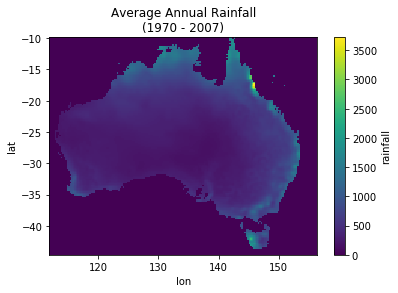

In [5]:
rainfall_yearly = []
for i in ds['year'].data:
    rainfall_yearly.append(ds.sel(year=i)['rainfall'].sum(dim='month'))
rainfall_avg = (sum(rainfall_yearly) / len(rainfall_yearly))
rainfall_avg.plot()
plt.title('Average Annual Rainfall\n(1970 - 2007)');

**1.4.**

Australia was in drought during the mid-2000's; let's look at it. Plot the total rainfall for 2006 using the same color axis as the annual average plotted above. How does the 2006 rainfall compare to the average rainfall field of the period?

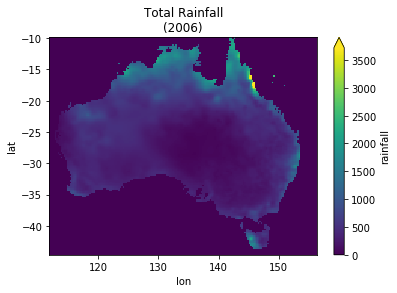

In [6]:
rainfall_2006 = ds.sel(year=2006)['rainfall'].sum(dim='month')
rainfall_2006.plot(vmax=rainfall_avg.max())
plt.title('Total Rainfall\n(2006)');

**1.5.**

Now use map algebra to plot the 2006 rainfall anomaly, which is the difference between the observed rainfall in a given location at a given time and the average rainfall at that location. If the anomaly at point $i$ in period $t$ is positive than $i$ should be experiencing greater than average rainfall. (When computing the average field, you still should include the observations for the year 2006).

**Which regions in Australia were hardest hit by the drought (in absolute rainfall terms)? What about as a percentage of the average rainfall experienced in a location? Turn in plots of the absolute and relative (i.e. percentage) anomaly in 2006.**

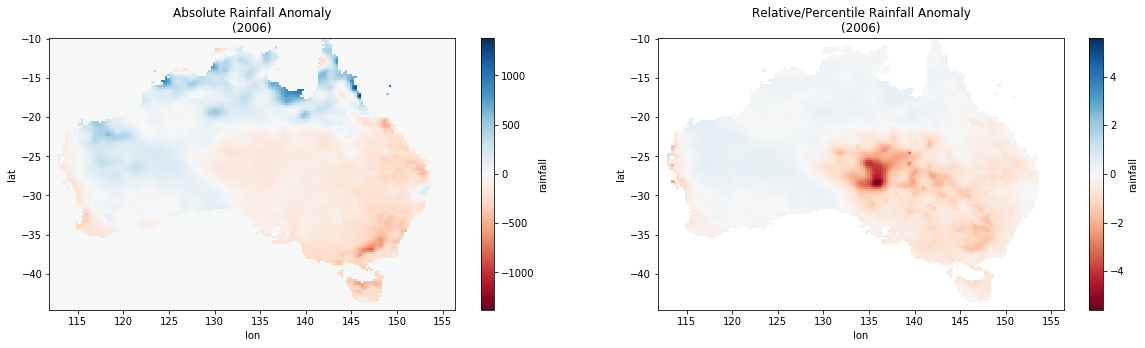

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))
rainfall_anom_avg = (rainfall_2006 - rainfall_avg)
rainfall_anom_rel = ((rainfall_2006 - rainfall_avg) / rainfall_2006)
rainfall_anom_avg.plot(ax=axes[0], cmap='RdBu')
rainfall_anom_rel.plot(ax=axes[1], cmap='RdBu')
axes[0].set_title('Absolute Rainfall Anomaly\n(2006)')
axes[1].set_title('Relative/Percentile Rainfall Anomaly\n(2006)');

**1.6.**

Pick a location in Australia that was hit hard by the drought and examine the time series of annual rainfall at that location for 1970-2007 (it can be a city or just an arbitrary location). 
**In a new figure with two subplots, first plot the map of the 2006 anomaly in one subplot (either one). On top of this image, mark the location that you will examine and label it clearly. In the second subplot, plot total annual rainfall in each year as a time series (so "years" is on the x-axis) at that location. Can you see the drought in the time series? Label this plot well.**

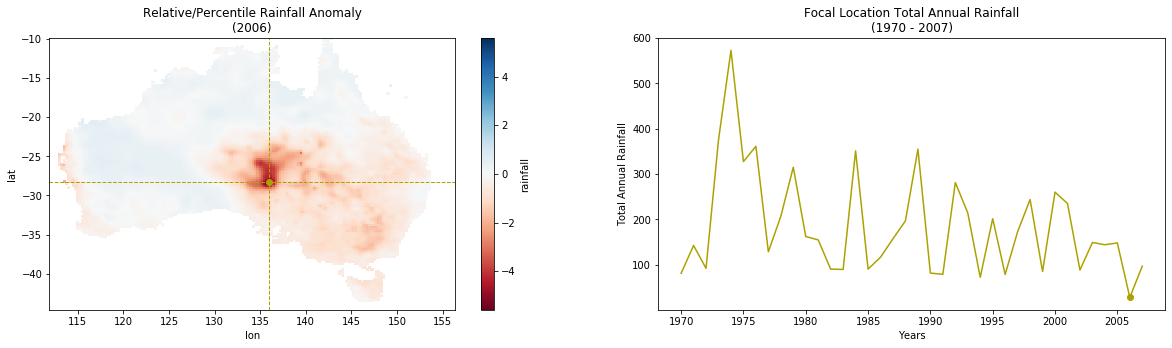

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))

focal_coords = [x[0] for x in np.where(rainfall_anom_rel == float(rainfall_anom_rel.min()))]
focal_loc = ((rainfall_2006 - rainfall_avg) / rainfall_2006)[focal_coords[0]][focal_coords[1]]
focal_yearly = [float(_[focal_coords[0]][focal_coords[1]].sum().data) for _ in rainfall_yearly]

rainfall_anom_rel.plot(ax=axes[0], cmap='RdBu')
axes[0].set_title('Relative/Percentile Rainfall Anomaly\n(2006)')
axes[0].axhline(focal_loc['lat'].data, ls='--', lw=1, color='#ADA100')
axes[0].axvline(focal_loc['lon'].data, ls='--', lw=1, color='#ADA100')
axes[0].plot(focal_loc['lon'].data, focal_loc['lat'].data, marker='o', color='#ADA100')
axes[1].plot(ds['year'].data, focal_yearly, color='#ADA100')
axes[1].plot(ds['year'].data[-2], focal_yearly[-2], marker='o', color='#ADA100')
axes[1].set_title('Focal Location Total Annual Rainfall\n(1970 - 2007)')
axes[1].set_ylabel('Total Annual Rainfall')
axes[1].set_xlabel('Years');

**1.7**

Now examine the distribution of rainfall over time at your chosen location. Extract the time series of annual rainfall at your location and compare it to a Normal distribution and a Poisson distribution. To generate random variables from a normal distribution, we need to specify the mean and standard deviation of the distribution `dist_mean` and `dist_sd` and then can generate a sample of 1000 points from this data generating process (DGP) through use of the code:

```python
normal_dgp = norm.rvs(size=1000, loc=dist_mean, scale=dist_sd)
```

To generate a sample from a poisson DGP, we can run 

```python
poisson_dgp = poisson.rvs(size=1000, mu=dist_mean)
```

noting that the poisson distribution only requires a mean argument.


**What kind of distribution does the distribution of annual rainfall look like to you? Compare these distributions as subplots in a single plot (or as subplots in the figure you made above in problem 1.6) and comment on which parametric distribution (Normal or Poisson) better characterizes the inter-temporal variation in annual rainfall over your chosen location. Mark the rainfall levels that were observed in 2006 on your plots of the distributions (however you like) and comment on how likely they seem based on the distribution of historical rainfall.**

Hint: for all of your plots using the matplotlib `hist()` function, supply the `density=True` argument to calculate the empirical pmf (probability mass function), rather than the raw count of the histogram as the y-axis, which will not be mutually comparable across different plots. The `vlines()` matplotlib function may also be helpful here.

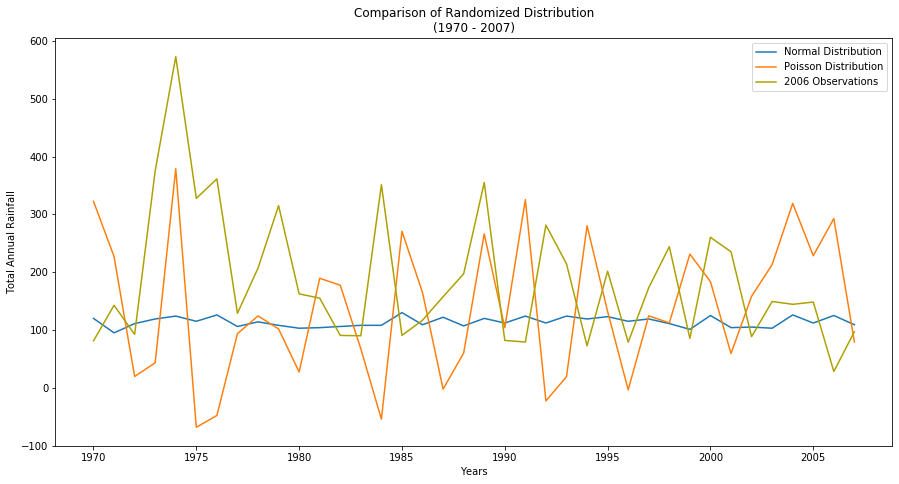

In [9]:
focal_mean, focal_mean = np.mean(focal_yearly), np.std(focal_yearly)
normal_dgp = norm.rvs(size=len(ds['year'].data), loc=focal_mean, scale=focal_mean)
poisson_dgp = poisson.rvs(size=len(ds['year'].data), mu=focal_mean)

fig, ax = plt.subplots(1,1, figsize=(15, 7.5))
ax.plot(ds['year'].data, poisson_dgp)
ax.plot(ds['year'].data, normal_dgp)
ax.plot(ds['year'].data, focal_yearly, color='#ADA100')
ax.legend(['Normal Distribution', 'Poisson Distribution', '2006 Observations'])
ax.set_title('Comparison of Randomized Distribution\n(1970 - 2007)')
ax.set_ylabel('Total Annual Rainfall')
ax.set_xlabel('Years');

**1.8. Plot the mean January and June rainfall (from Question 1.2) in the first two panels of a figure. How does the correlation in average January rainfall and average June rainfall vary across the country?**

Answer this question by computing a moving window regression where you regress average June rainfall on average January rainfall across locations within a window. Use a window that is 21 pixels by 21 pixels (10 pixels on each side of the center pixel) and record the regression coefficient at the location of the center pixel (in a new field that you construct). 

Because the data in your window is a rectangle of data in your field, you will need to convert it to a (column) vector before you can run a regression using it.

There are several ways to do this. One way to do it is to use the numpy command flatten (i.e. ```np.array(data_in_window).flatten()```). 

Likewise, there are several ways to run a regression in python. One way is to use the ```linregress``` command provided by scipy. Suppose our regression data was
```python
x = [1, 2, 3]
y = [3, 4, 5]
```
then the command `b = linregress(x, y)` would run a regression of `y` on `x` with an intercept, where `b[0]` returns the slope of the regression, and `b[1]` returns the y-intercept.

Alternately, we could use numpy and linear algebra to calculate the regression coefficients manually. Recalling the formula for the OLS coefficients are the equation $(X^TX)^{-1}X^Ty$, then the following lines will solve for `b`, where we  will need to add a column of ones as an additional column to your matrix for `X` to include an intercept.

```python
X = np.array([np.ones(len(x)), x]).T  # creates a 3x2 array from a vector of 1s & x
Y = np.array([y]).T  # creates a 1x2 array from y
b = inv(X.T.dot(X)).dot(X.T.dot(Y))  # performs the linear algebra
```

Here, the resulting vector `b` contains two elements. The first would be the y-intercept (since it corresponds to the column of ones) and the second would be the slope (since it corresponds with the vector `x`). 

Make sure to debug your code using a limited sample from the full data set. Since it may take some time to run, you will want to make sure it is working before attempting a run using the full data set. An easy way to work with a limited sample of data is to just run the code on a section of data in the middle of the country (eg. if you wrote for loops, just change the endpoints so you only look at data in the middle of the country: e.g., `for i in range(100, 140)` rather than `for i in range(end_of_range)`. Hint: writing a function here would be wise.

**Once you have your moving window regression working, plot the field that describes the regression coefficient for January rainfall in the third panel of your figure (don't bother plotting the constant term). Is the coefficient the same across the country? In a sentence, interpret this map.**

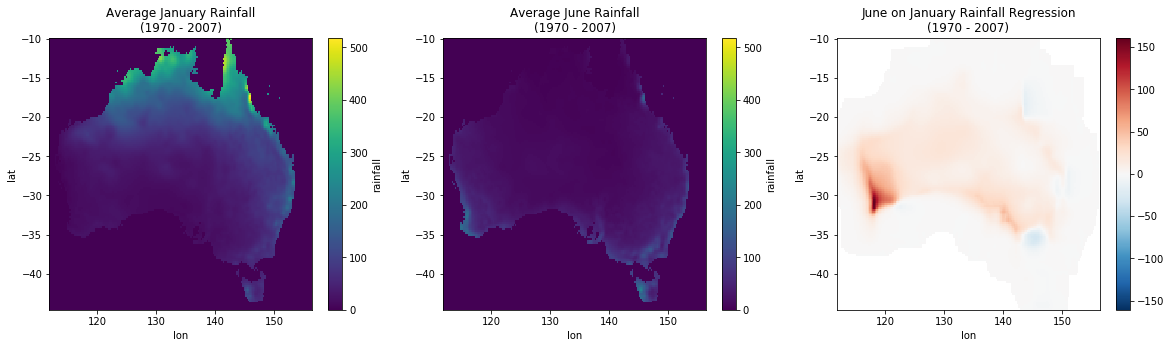

In [10]:
def mw_regression_xr(x, y, window=10):
    def mw_regression(x, y, i, j, window):
        min_i, min_j = max(0, i - window), max(0, j - window)
        max_i, max_j = min(x.shape[0], i + window), min(x.shape[1], j + window)
        x_sub, y_sub = x[min_i:max_i, min_j:max_j], y[min_i:max_i, min_j:max_j]
        if (x_sub.sum() == 0 or y_sub.sum() == 0 or np.isnan(x_sub.sum()) or np.isnan(y_sub.sum())):
            return np.nan
        return linregress(x_sub.flatten(), y_sub.flatten())[1]
    x, y = x.data, y.data
    assert x.shape == y.shape, 'Must regress over same space.' 
    grid = np.full_like(x, np.nan)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            grid[i, j] = mw_regression(x, y, i, j, window=window)
    return xr.DataArray(grid, dims=('lat', 'lon'), coords={'lat': ds['lat'], 'lon': ds['lon']})

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
rainfall_jan_jun = mw_regression_xr(rainfall_jan, rainfall_jun)
rainfall_jan.plot(ax=axes[0], vmax=cmax)
axes[0].set_title('Average January Rainfall\n(1970 - 2007)')
rainfall_jun.plot(ax=axes[1], vmax=cmax)
axes[1].set_title('Average June Rainfall\n(1970 - 2007)')
rainfall_jan_jun.plot(ax=axes[2])
axes[2].set_title('June on January Rainfall Regression\n(1970 - 2007)');

No, the relationship between January and June rainfall seems to be greatest in southwestern Australia, while it is least in southeastern Australia. 

## 2. Bazaar Optimality

You have been asked by the World Bank to identify the best location for 22 marketplaces that they plan to build in Guatemala, one for each of the 22 _departamentos_ (the first administrative unit in Guatemala). For each _departamento_, the location of the marketplace should be selected to reduce the travel cost to and from the market for residents throughout that _departamento_. However, you must also take into account the distance from the market to Guatemala City ($14.6^{\circ}N ~ 90.5^{\circ}W$), since that is the central hub where merchants will be traveling to and from with their products for each regional market. The task for you is to select an approximate location within each departamento that minimizes total expected travel cost to and from the market for all Guatemalans, both within the region and between the market and Guatemala City. 

For simplicity, you should assume that (i) the curvature of the Earth does not matter for this problem, so assume that $1^{\circ}$ of longitude is the same distance regardless of the latitude (but is not
equivalent to $1^{\circ}$ of latitude; (ii) the population of Guatemala is uniformly distributed in each _departamento_; (iii) travel within a _departamento_ is equally costly per unit distance as travel between a market and Guatemala city; (iv) travel time depends only on Euclidean distances (e.g. you can ignore where actual roads are). 

Because this problem requires that you do a similar calculation 22 times (once for each _departamento_), you should write your code in a such a way that it can eventually be run in a loop that repeats the same calculation for different _departamentos_. However, to avoid trying to debug that large loop, first do the calculations for a single _departamento_ and then generalize the code to run inside a loop. Also, we will write a function to simplify some of the distance calculations, but if you spot other locations where you can write a function that you will call many times, go for it.

**2.1.**

Start by obtaining the shapefile for Guatemalan departamentos at http://www.diva-gis.org. Because the _departamentos_ are the first administrative unit, their boundaries are contained in the file named `GTM_adm1.shp`. Import the shapefile as a geopandas dataframe (see Lab 4).

Unlike the previous boundary file we looked at, this one is slightly more complicated because there are multiple polygons rather than just the single polygon that you looked at before.  In the earlier lab where you plotted a country, there was only one object in that shapefile (the country boundary) so you didn’t worry about the index. The indexing system used by geopandas for these geographic data structures is simple (and very similar to pandas).

Let's start by examining the geopandas dataframe we read in above by running ```df```. Each row here represents a different _departamento_. As before, the associated information for each _departamento_ (i.e. their names, abbreviations, etc.) is stored as columns in this dataframe, very similar to pandas. Recall that the main difference is the column in each GeoDataFrame named `'geometry'`, each row of which is a shapely MultiPolygon object.

To examine the shapely MultiPolygon object for the polygon stored in the shapefile (the first _departamento_) you would type ```df['geometry'][0]``` (in general, check that df.index is ordered from 0-N for this to work, as df.index may be composed of strings, or not in order, etc. -- to ensure that df.index is ordered from 0-N, you can run ```df.index = range(len(df))```). This is an easy way to visualize one shapely MultiPolygon at a time.

But what about visualizing all of the departamentos?

**Write code that plots all the departamentos on a single plot. Hint: you may have done this before.**

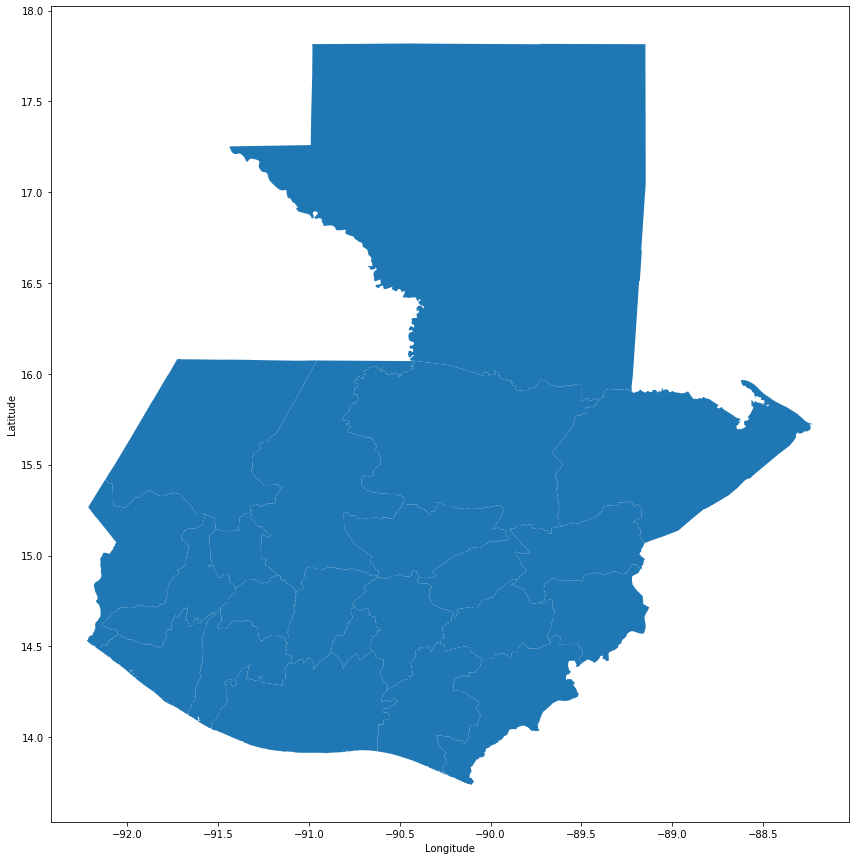

In [2]:
df = gpd.read_file('GTM_adm/GTM_adm1.shp')
guat_shp = gpd.read_file('GTM_adm/GTM_adm0.shp').geometry[0]
df.plot(figsize = (15,15))
guatemala_city = (-90.5, 14.6)
plt.xlabel('Longitude') and plt.ylabel('Latitude')
cmap='cividis';

**2.2**

For the sake of the optimization problem, break each _departamento_ into $0.1^{\circ} \times 0.1^{\circ}$ squares that we will use as the units of analysis. We'll assume that there is one individual who lives in each square (one could also assume there are N individuals in each square and it wouldn't change the analysis) and that each square is a potential location for a market. In addition, assume that each individual travels to and from the market once per week and that in order to supply that individual with goods, a merchant must travel from the market to Guatemala City and back. In other words, the number of trips from market to Guatemala City and back is equal to the number of individuals in a _departamento_. (For squares that are on the border between two _departamentos_, you may decide how to handle them. You could assume that there is only one half of an individual in that location per _departamento_ or you could just count that square twice, once for each _departamento_ that enters it. You could also assume something else if you think it is appropriate and does not introduce too much error.)

Construct a mask for each _departamento_. To make things easy for yourself, the lat-limits and lon-limits that you use when constructing each mask should be same for each _departamento_. So each mask should be of the same size. There are multiple ways to do this - you could store each mask in a three dimensional array or in a geopandas GeoDataFrame.

**Check that your masks look right by plotting a single mask and then overlaying the boundary of the corresponding _departamento_ on that plot. Check that at least two of your masks look correct before continuing (turn them both in).**

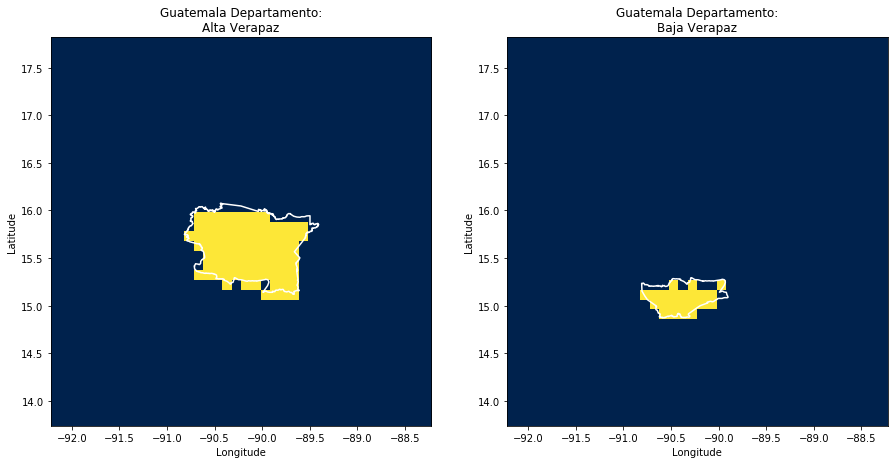

In [3]:
lon_min = min(df.geometry[16].exterior.xy[0])
lon_max = max(df.geometry[8][1].exterior.xy[0])
lat_min = min(df.geometry[10][2].exterior.xy[1])
lat_max = max(df.geometry[11].exterior.xy[1])

delta = 0.1
masks = np.array([geometry_mask(geometries=[geom],
                               out_shape=(int((np.round(lat_max - lat_min))/delta),
                                         int((np.round(lon_max - lon_min)/delta))),
                               transform=Affine(delta, 0, lon_min, 0, -delta, lat_max),
                               all_touched=False,
                               invert=True) for geom in df['geometry']])

extent = (lon_min, lon_max, lat_min, lat_max)
fig, axes = plt.subplots(1, 2, figsize=(15,10))
for i in (0, 1):
    axes[i].imshow(masks[i, :, :], extent=extent, cmap=cmap)
    axes[i].plot(*df.loc[i, 'geometry'].exterior.xy, 'w-')
    axes[i].set_xlabel('Longitude') and axes[i].set_ylabel('Latitude')
    axes[i].set_title('Guatemala Departamento:\n' + df['NAME_1'][i])

**2.3.**

Now we are going to solve the optimal market location for a single _departamento_. We'll then later adjust the code and build it into a loop to repeat the analysis for all of the departamentos. To find the optimal market location, we need to break the problem down into determining which locations are feasible, computing our cost function for each location, then finding the location where the cost function is minimized. Below is a description for one approach to solving this problem, but you __do not__ have to follow it. There are multiple ways to solve this problem and if you would like to try doing it a different way, that is okay. (If you are going to follow the instructions below, I recommend reading through them once completely to make sure you have a sense of the plan – I also recommend mapping out what calculations you are doing on a scrap piece of paper since there will be several moving parts.)

- (a) Start by picking a single _departamento_ to work with. For this _departamento_, the market must be located within the _departamento_ (on one of our mask squares that has a value of 1 in the mask, as opposed to 0). Our code will eventually search through all the possible square locations, so we'll want the first thing it does when looking at a location to be to determine if that square is a feasible location for the market. Start by writing a loop that looks at each square in the mask and identifies whether that square is in the _departamento_ using an if statement (see Lab 2). (Hint: Just to make sure this is working the way you think it is, you can have your script plot a point at each square if it thinks it is in the _departamento_, that way you can visually check if you are identifying the correct locations.).

- (b) Next, we need to determine what our cost function is given a potential market location. To do this, we'll need to compute the travel distance from each grid inside the _departamento_ to the potential market location, as well as between Guatemala City and the potential market location. This is going to involve a lot of distance calculations, so it would probably be a good idea to write a function that will measure distance the way we want to compute it for this problem. Let's write a function that computes the distance between a single point (the potential market location) and a matrix of locations that is constructed with `np.meshgrid` (see Lab 5). If we do this, we can create a matrix that describes the locations of each grid in our masks (even the ones that are zeros) and we can compute each locations' distance to the potential market with a single command (once we have these distances for all locations in the grid, we can do map algebra with the correct mask to zero-out the locations outside of the _departamento_). You could write this function as

```python
def dist_matrix(pointX, pointY, matX, matY):
    """Computes distances between a point and a collection of points.
    
    Args:
        pointX, pointY (float) 
        matX, matY (numpy.ndarray): should be the same size

    Returns:
        numpy.ndarray: describes the distance between each grid and a single point
    """
    return np.sqrt((pointX - matX) ** 2 + (pointY - matY) ** 2)
```

Notice that this function will work to compute the distances for all locations in the grid simultaneously, as well as to compute the distance between the potential market and Guatemala City. Using this `dist_matrix` function, compute and display the cost function for each potential market location inside the loop you wrote for (2.3.a). As hinted before, once you have used `dist_matrix` to compute the distance from each grid in a mask to the potential market, use map algebra to remove the distances that are to grids outside of the _departamento_. To sum up travel costs for each grid in the _departamento_, you can apply sum twice to the masked-out matrix of distances. Be sure to add in the cost of merchants traveling to and from Guatemala City, and be sure that the number of merchants traveling that distance is equal to the number of grids inside the _departamento_. Once you have computed the cost function for a single potential market location, you must store that value somewhere. Make a new matrix of NaNs that is the same size as the mask you are using

```python
nan_matrix = np.empty((row_size_mask, col_size_mask))
nan_matrix[:] = np.nan
```

and replace entries that correspond with potential market locations with the value of the cost function at that location. Once you have run your loop through all potential locations, computing and recording the cost function at each location, this new matrix can be visualized to display the cost function at each grid in the _departamento_.

- (c) Find the location with the minimum value of the cost function (if you used NaNs, make sure to use ```np.nanmin``` or any other function that ignores NaNs).

Demonstrate that your code works for a single _departamento_ by visualizing your calculation and result in a single map. Make a heat map of the cost function with the boundary of the _departamento_ overlaid on top. Plot the optimal location of the market for that _departamento_ using a marker. Demonstrate the structure of that the trade network will take if that location is selected by drawing a line from each grid in the departamento to the market (this is the travel distance for each individual in the departamento) and a line from the market to Guatemala City (this is the travel distance for all of the merchants).

**Turn in this single plot as your answer to (3), regardless of whether or not you followed the steps above or used a different approach.**

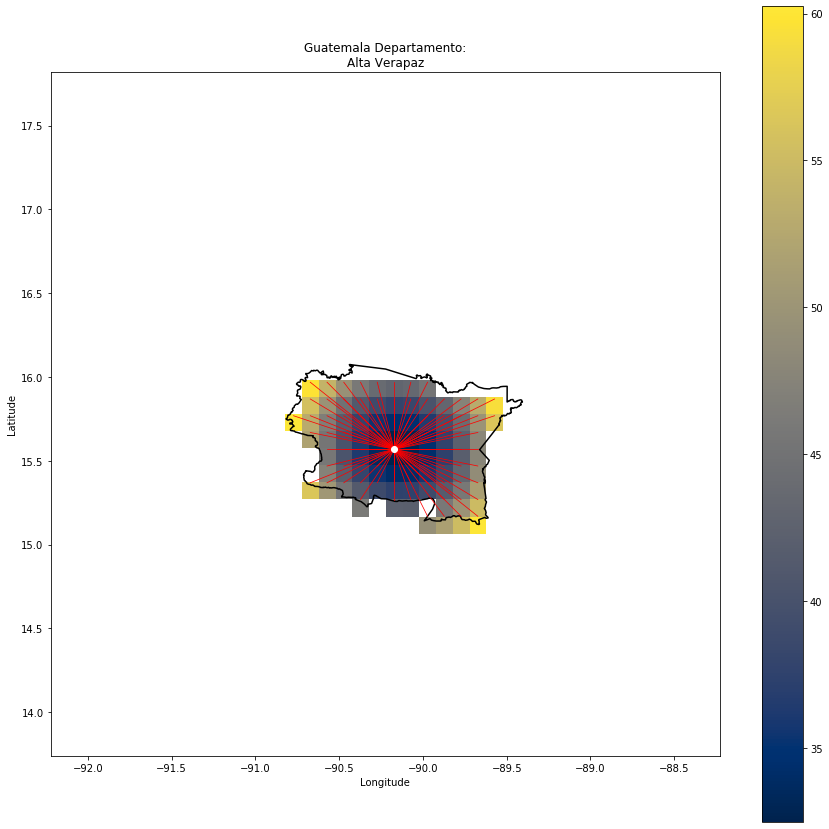

In [12]:
def dist_matrix(matrix, gc_weight=1):
    """Computes distances between a point and a collection of points.

    Args:
        matrix (numpy.ndarray): should be the same size
        gc_weight: weight given to distance from Guatemala City for a given location

    Returns:
        dst_matrix (numpy.ndarray): describes the distance between each grid and a single point
        
    """
    def dist_helper(coords, matrix=matrix, gc_weight=gc_weight):
        i, j = coords
        x, y = np.array(matrix[matrix != 0].tolist() + [(-90.5, 14.6)] * gc_weight).T
        return np.sqrt((i - x) ** 2 + (j - y) ** 2)
    dst_matrix = np.full_like(matrix, np.nan, dtype=float)
    for row, i in enumerate(matrix):
        for col, j in enumerate(i):
            if type(j) is tuple:
                dst_matrix[row][col] = dist_helper(j).sum()
    return dst_matrix

loc_matrix = np.full_like(masks, 0, dtype=tuple)
                
for arr, i in enumerate(masks):
    for row, j in enumerate(i):
        for col, k in enumerate(j):
            if k != 0:
                loc_matrix[arr][row][col] = xy(Affine(delta, 0, lon_min, 0, -delta, lat_max), row, col)

dep = 0
dep_matrix = dist_matrix(loc_matrix[dep])
opt_index = np.where(dep_matrix == np.nanmin(dep_matrix))
opt_x, opt_y = loc_matrix[dep][opt_index][0]
    

fig, ax = plt.subplots(figsize=(15,15))
im = plt.imshow(dep_matrix, extent=extent, cmap=cmap)
ax.plot(*df.loc[dep, 'geometry'].exterior.xy, 'k-')
for loc in loc_matrix[dep][loc_matrix[dep] != 0]:
    ax.plot([opt_x, loc[0]], [opt_y, loc[1]], 'r-', lw=0.75)
ax.plot(opt_x, opt_y, 'wo')
fig.colorbar(im, ax=ax)
ax.set_xlabel('Longitude') and ax.set_ylabel('Latitude')
ax.set_title('Guatemala Departamento:\n' + df['NAME_1'][dep]);

In [26]:
for i, j in enumerate(dep_matrix):
    print(i)
    print(j)

0
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
1
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
2
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
3
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
4
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
5
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
6
[n

**2.4**

Now adjust your code so that the calculation you ran for a single _departamento_ is run for all 22 _departamentos_ (you should just add a loop outside of your script, rather than cut-and-pasting your code 21 times). Make sure that you create vectors that will record the location of each market. 

**Display your results by plotting the location of each market on a single map of the departamento boundaries, along with the trade network for each departamento.**

To make your display clear, you will want to adjust the weight of lines in the boundaries or the trade network or make lines of a certain type a distinct color. Optionally, color each grid cell relative to the total cost for that grid cell (cost of commuting from the grid cell to the market and from the market to Guatemala City).

**Finally, report the list of coordinates for the 22 optimally-located markets that you are recommending the World Bank builds.**

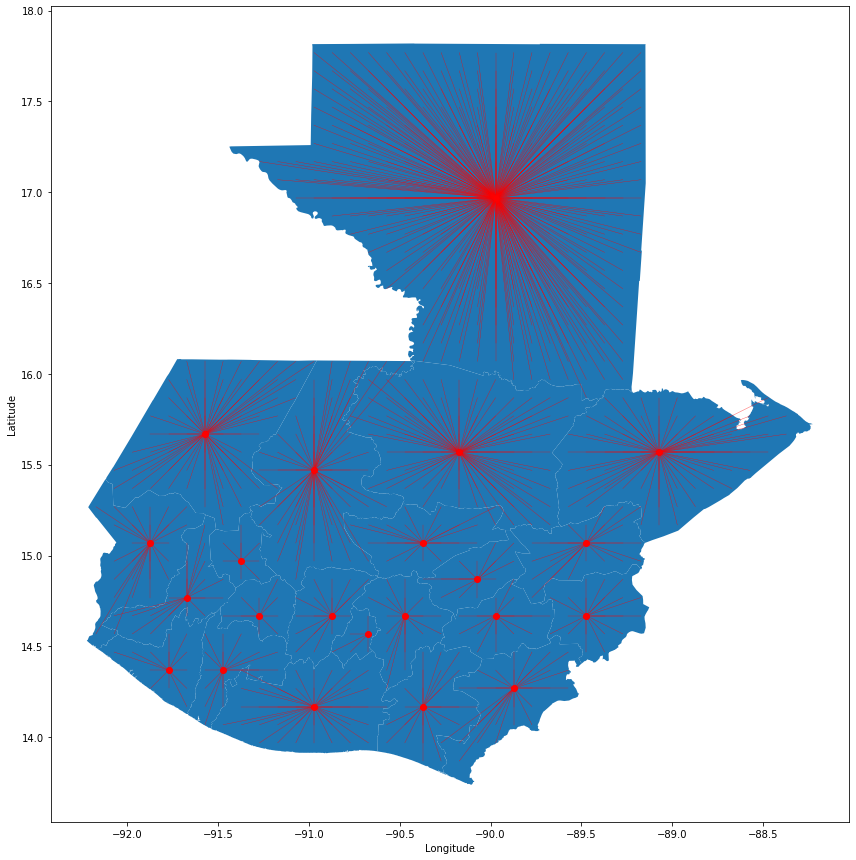

In [5]:
market_locs = []
for dep in loc_matrix:
    market_locs.append(dep[np.where(dist_matrix(dep) == np.nanmin(dist_matrix(dep)))][0])

fig, ax = plt.subplots(figsize=(15,15))
for i, (loc_x, loc_y) in enumerate(market_locs):
    ax.plot(loc_x, loc_y, 'ro')
    for j in loc_matrix[i][loc_matrix[i] != 0]:
        ax.plot([loc_x, j[0]], [loc_y, j[1]], 'r-', lw=0.3)
df.plot(ax=ax)
ax.set_xlabel('Longitude') and ax.set_ylabel('Latitude');

In [6]:
print('Guatemala Market Locations by Departamento\n(Longitude, Latitude)\n')
for i, loc in enumerate(market_locs):
    print(df['NAME_1'][i] + ':' + str(loc))

Guatemala Market Locations by Departamento
(Longitude, Latitude)

Alta Verapaz:(-90.17235870361328, 15.56871414184576)
Baja Verapaz:(-90.37235870361329, 15.06871414184576)
Chimaltenango:(-90.87235870361329, 14.66871414184576)
Chiquimula:(-89.47235870361328, 14.66871414184576)
El Progreso:(-90.07235870361329, 14.868714141845759)
Escuintla:(-90.97235870361328, 14.16871414184576)
Guatemala:(-90.47235870361328, 14.66871414184576)
Huehuetenango:(-91.57235870361329, 15.66871414184576)
Izabal:(-89.07235870361329, 15.56871414184576)
Jalapa:(-89.97235870361328, 14.66871414184576)
Jutiapa:(-89.87235870361329, 14.26871414184576)
PetÃ©n:(-89.97235870361328, 16.96871414184576)
Quezaltenango:(-91.67235870361328, 14.76871414184576)
QuichÃ©:(-90.97235870361328, 15.468714141845759)
Retalhuleu:(-91.77235870361328, 14.368714141845759)
SacatepÃ©quez:(-90.67235870361328, 14.56871414184576)
San Marcos:(-91.87235870361329, 15.06871414184576)
Santa Rosa:(-90.37235870361329, 14.16871414184576)
SololÃ¡:(-91.272

## Congratulations!
You've finished this lab!

* **Please list everyone you worked on this assignment with outside of public Piazza discussions.**
    * *Luke*